## MNIST 

In [1]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

In [2]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [3]:
y.shape

(70000,)

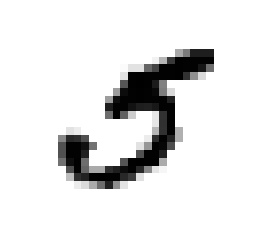

In [4]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,
          interpolation="nearest")
plt.axis("off")
plt.show()

In [5]:
y[36000]

5.0

前60000个为训练集，后10000个为测试集

In [6]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

对训练数据集进行随机，因为要保证每个交叉验证集的fold数据相似，而且某些算法对可能对训练数据的顺序敏感

In [7]:
import numpy as np
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## Training a Binary Classifier 

这里简化问题，只做一个二元分类器，检测是不是数字5，目标向量： 

In [8]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

选择一个分类器并进行训练，在这里选择Stochastic Gradient Descent(SGD)分类器

In [9]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=22)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=22, shuffle=True, verbose=0,
       warm_start=False)

In [10]:
sgd_clf.predict([some_digit])

array([ True], dtype=bool)

## Performance Measures 
相比回归模型，评价一个分类模型的好坏更难，会有更多的评价指标

### Measuring Accuracy Using Cross-Validation 
使用交叉验证:

In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=22)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.95895
0.9634
0.9511


使用cross_val_score()函数可以代替以上代码评价SGDClassifier

In [12]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([ 0.95895,  0.9634 ,  0.9511 ])

看上去有95%的正确率挺不错的，但是下面来看一个很挫的分类器，把每张图片都分到“not-5”类：

In [13]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [14]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([ 0.9102 ,  0.91245,  0.9063 ])

### Confusion Matrix
更好的一种评价分类器性能的方法是使用混淆矩阵（错误矩阵）。主要原理是计算有多少个类A被分类到类B。举例：要知道有多少个5被分类到3，可以查看混淆矩阵的第5行第3列

In [15]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [16]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[52897,  1682],
       [  849,  4572]])

混淆矩阵的每一行表示数据实际上所属的类别，每一列代表一个预测出的类。比如，这个矩阵的第一行表示原本non-5的图片，有52897张正确的分类为non-5(ture negative)，有1682被分类到了5(false positives)。第二行表示原本类别为5的图片，有849张被分类到了non-5(false negative), 有4572被分类到了5(true positives)

准确率：$$precision = \frac{TP}{TP + FP}$$

召回率：$$recall = \frac{TP}{TP + FN}$$

### Precision and Recall

In [37]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred) # == 4572 / (4572 + 1682)

0.73105212663895103

In [36]:
recall_score(y_train_5, y_train_pred) # == 4572 / (4572 + 849)

0.84338682899833983

为了方便可以把准确率和召回率结合成一个F1 score:
$$F_{1} = \frac{2}{\frac{1}{precision} + \frac{1}{recall}} = 2 \times \frac{precision\times recall}{precision+recall} = \frac{TP}{TP+\frac{FN+FP}{2}}$$

In [41]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.78321199143468956

### Precision/Recall Tradeoff 

In [26]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([ 196442.03163998])

In [27]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True], dtype=bool)

In [28]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False], dtype=bool)

In [29]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                            method="decision_function")

In [30]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

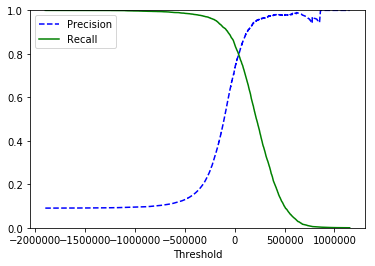

In [32]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [33]:
y_train_pred_90 = (y_scores > 70000)
precision_score(y_train_5, y_train_pred_90)

0.84070434070434075

In [34]:
recall_score(y_train_5, y_train_pred_90)

0.7574248293672754

### The ROC Curve 
接收者操作特征曲线(receiver operating characteristic)是另一种常用的评价二元分类器的工具。和准确率/召回率曲线比较类似，但是ROC描绘true positive rate(recall的另一个名称)和false positive rate。FPR是negative instances错误的被分类为positive的比例，等于1减true negative rate。TNR也称为specificity。因此ROC描绘sensitivity(recall)和1-specificity之间的关系。

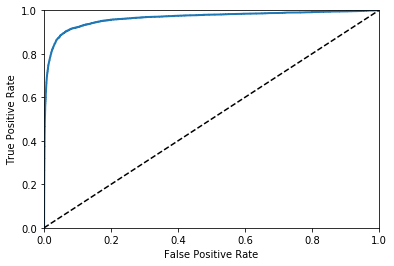

In [35]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(fpr, tpr)
plt.show()

这里也有一个折衷：recall(TPR)越高，假阳性的分类结果会越多。斜虚线表示随机分类的结果，一个好的分类器应该离斜虚线的距离尽可能远，即左上角。
比较分类器的方法是评价area under the curve(AUC)，理想的分类器ROC AUC等于1，完全随机的分类器ROC AUC等于0.5

In [42]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.96464069542813169

训练一个随机森林分类器(RandomForestClassifier)然后对比SGDClassifier的ROC曲线和ROC AUC分值

In [44]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=22)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                  method="predict_proba")

In [58]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

/Users/tweinyan/.pyenv/versions/3.6.2/envs/venv36/lib/python3.6/site-packages/matplotlib/legend.py:326: UserWarning: Unrecognized location "bottom right". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


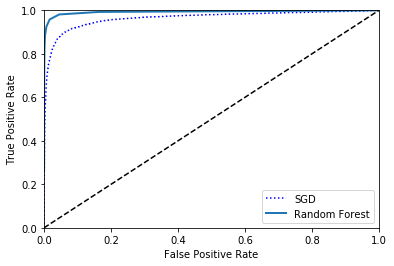

In [59]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="bottom right")
plt.show()

如图，RandomForestClassifier的ROC曲线比SGDClassifier的更好，更接近左上角，ROC AUC分值也明显更好:

In [60]:
roc_auc_score(y_train_5, y_scores_forest)

0.99303351208483515

## Multiclass Classification 

In [61]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([ 5.])

In [63]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-449655.27368045, -542845.59743313, -231038.66475092,
        -106373.96415783, -359887.33878109,  196442.03163998,
        -733632.40219842, -298250.67391594, -595401.54571247,
        -539857.74384257]])

In [64]:
np.argmax(some_digit_scores)

5

In [65]:
sgd_clf.classes_

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.])

In [67]:
sgd_clf.classes_[5]

5.0

In [68]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=22))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([ 5.])

In [69]:
len(ovo_clf.estimators_)

45

In [72]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([ 5.])

In [73]:
forest_clf.predict_proba([some_digit])

array([[ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]])

In [74]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([ 0.85577884,  0.86784339,  0.86317948])

In [75]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([ 0.90956809,  0.90819541,  0.91138671])

## Error Analysis

In [76]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5734,    3,   19,   13,   10,   46,   41,   11,   43,    3],
       [   2, 6510,   40,   27,    6,   35,    8,   11,   92,   11],
       [  56,   38, 5340,  105,   83,   18,   87,   52,  162,   17],
       [  42,   44,  132, 5383,    4,  207,   33,   48,  126,  112],
       [  19,   30,   43,    8, 5356,   10,   51,   26,   80,  219],
       [  66,   47,   37,  194,   77, 4576,  111,   27,  183,  103],
       [  34,   26,   47,    2,   37,   90, 5628,    7,   47,    0],
       [  22,   23,   73,   31,   52,   10,    5, 5774,   18,  257],
       [  49,  169,   73,  164,   12,  145,   54,   24, 5008,  153],
       [  43,   39,   32,   90,  156,   31,    2,  206,   76, 5274]])

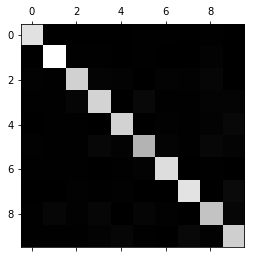

In [77]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [78]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

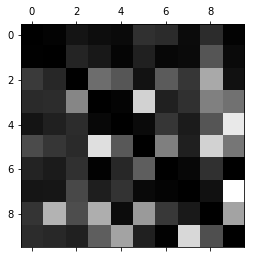

In [79]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

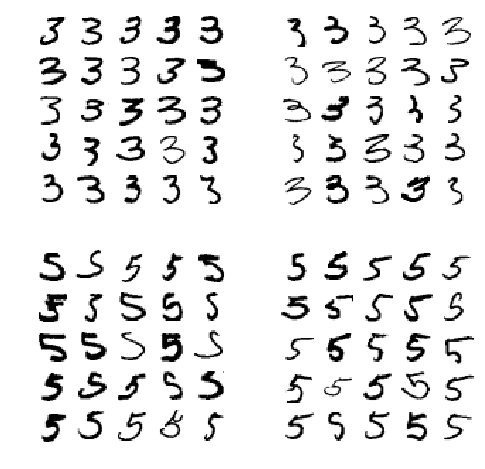

In [84]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size, size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap=matplotlib.cm.binary, **options)
    plt.axis("off")
    
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)] 
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]
plt.figure(figsize=(8, 8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

### Multilabel Classification 

In [85]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)
knn_clf.predict([some_digit])

array([[False,  True]], dtype=bool)